# Necessary requirement
If we want to have a completely accurate output, we should identify the parking lots **Manually**. For doing this, we just need to run the source code which is attached to the root folder (regions.py) on terminal and detect the parking lots manually with 4 points(Polygon).

# Mount the google drive

In [ ]:
from google.colab import drive  
drive._mount('/content/drive')  

Mounted at /content/drive


# Installing some specific version of **Tensorflow** and **Keras** libraries and their dependencies

In [ ]:
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.1.6

     |████████████████████████████████| 411.5 MB 8.0 kB/s 
     |████████████████████████████████| 3.8 MB 37.3 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 503 kB 41.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=a6f0efcd243bbd0346467e4b4309c09e6d37a5c3bfd1d8e3c36fca8e8a9140cc
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succe

In [ ]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 5.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.1.6 which is incompatible.
tensorflow 2.7.0 requires tensorboard~=2.6, but you have tensorboard 1.15.0 which is incompatible.
tensorflow 2.7.0 requires tensorflow-estimator<2.8,~=2.7.0rc0, but you have tensorflow-estimator 1.15.1 which is incompatible.


# Installing some required libraries

In [ ]:
import numpy as np
import cv2
from pathlib import Path
from google.colab.patches import cv2_imshow
import pickle

from shapely.geometry import box
from shapely.geometry import Polygon as shapely_poly
from IPython.display import clear_output, Image, display, HTML
import io
import base64
%matplotlib inline

## Clone the Matterpot implemented Mask-RCNN repository
Using the pretrained model helps you to have an accurate and powerful model

In [ ]:
# !git clone https://github.com/matterport/Mask_RCNN

import os
os.chdir("/content/drive/MyDrive/CV_project/Mask_RCNN/")
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

### Configuring Mask-RCNN
* As the Mask_RCNN trained on **80** different classes, so we have to set the **NUM_CLASSES** to 81: **Background + 80**

* It also uses some configurations from pre-trained matterport's model

In [ ]:
class Config(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 81
config = Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

###  path of Model & COCO pre-trained Model

In [ ]:
ROOT_DIR = Path(".")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [ ]:
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

# Loading pre-trained model 
To have the best output first we need to download the weight from the matterport's repository, then load the model with **inference** mode.

In [ ]:
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=Config())







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model.load_weights(COCO_MODEL_PATH, by_name=True)

### Uploading data
upload your video file and detected praking regions by the regions.py output file.

In [ ]:
VIDEO_SOURCE = "/content/drive/MyDrive/CV_project/Mask_RCNN/uni_test.mov"
PARKING_REGIONS = "/content/drive/MyDrive/CV_project/Mask_RCNN/final_regions.p"
with open(PARKING_REGIONS, 'rb') as f:
    parked_car_boxes = pickle.load(f)

### Function to filter out car boxes

In [ ]:
# COCO predefined classes

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
# function to draw a box around the cars 
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / bus / truck in order 3,8,6, skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

### Function to compute IoU(Computation of Intersection Over Union)

In [ ]:
def compute_overlaps(parked_car_boxes, car_boxes):
    
    new_car_boxes = []
    #having coordinates of the car_boxes (lots which detected as occupied)
    for box in car_boxes:
        y1 = box[0]
        x1 = box[1]
        y2 = box[2]
        x2 = box[3]
        
        p1 = (x1, y1)
        p2 = (x2, y1)
        p3 = (x2, y2)
        p4 = (x1, y2)
        new_car_boxes.append([p1, p2, p3, p4])
    #computing overlaps the given region (boxes from pickle file) and occupied by pre-trained model 
    overlaps = np.zeros((len(parked_car_boxes), len(new_car_boxes)))
    for i in range(len(parked_car_boxes)):
        for j in range(car_boxes.shape[0]):
            pol1_xy = parked_car_boxes[i]
            pol2_xy = new_car_boxes[j]
            polygon1_shape = shapely_poly(pol1_xy)
            polygon2_shape = shapely_poly(pol2_xy)
            # intersections between the areas
            polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
            polygon_union = polygon1_shape.union(polygon2_shape).area
            IOU = polygon_intersection / polygon_union
            overlaps[i][j] = IOU

    return overlaps

### Function to display processed images
This function helps us to encode the images to be supported from google colab. we will need this to create the video for the result of each frames.

In [ ]:
def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

# Processing Pipeline
* First we need to upload the recorded video from a camera(it can work realtime(linking the realtime video to cv2.VideoCapture(VIDEO_SOURCE)))

* Dividing the video into frames

* Computing the overlaps between regions and car_boxes

* Making decision which is empty or occupied

* Creating the video from output frames

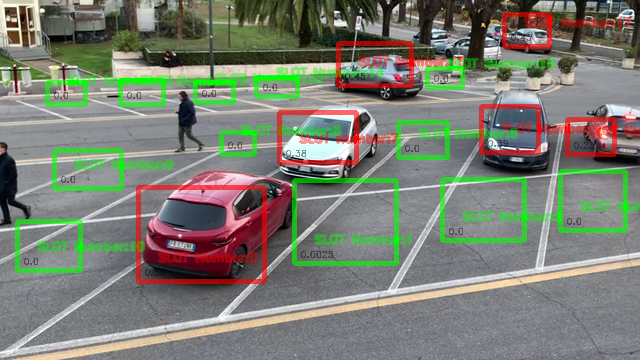

AttributeError: ignored

In [ ]:
alpha = 0.6
#Getiing the video 
video_capture = cv2.VideoCapture(VIDEO_SOURCE)

#This part is for creating the output video 
video_FourCC    = cv2.VideoWriter_fourcc('M','J','P','G')
video_fps       = video_capture.get(cv2.CAP_PROP_FPS)
video_size      = (int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
                    int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
out = cv2.VideoWriter("final_test_out_uni_sample.avi", video_FourCC, video_fps, video_size)

# Loop over each frame in the video
cnt=0
Empty = 0
Occupied = 0
while video_capture.isOpened():
    success, frame = video_capture.read()
    overlay = frame.copy()
    if not success:
        break
    # Converting the image from BGR color used by OpenCV to RGB color
    rgb_image = frame[:, :, ::-1]
    results = model.detect([rgb_image], verbose=0)
    # results['rois'] are the bounding box of each detected object
    # results['class_ids'] are the class id (type) of each detected object
    car_boxes = get_car_boxes(results[0]['rois'], results[0]['class_ids'])
    overlaps = compute_overlaps(parked_car_boxes, car_boxes)

    slot = []
    font = cv2.FONT_HERSHEY_DUPLEX 
    number = 0

    for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):
      # Get the top-left and bottom-right coordinates of the parking lots
      x1, y1 = parking_area[0]
      x2, y2 = parking_area[1]
      x3, y3 = parking_area[2]
      x4, y4 = parking_area[3]

      fx1 = min(x1,x2,x3,x4)
      fx2 = max(x1,x2,x3,x4)
      fy1 = min(y1,y2,y3,y4)
      fy2 = max(y1,y2,y3,y4)
      # Check if the parking space is occupied by seeing if any car overlaps
      # it by more than 0.15 using IoU
      max_IoU_overlap = np.max(overlap_areas)
      if max_IoU_overlap < 0.15:
        # Parking space not occupied,So draw a green box around it
        cv2.rectangle(overlay, (fx1, fy1), (fx2, fy2), (0, 255, 0), 3)
        cv2.putText(frame, "SLOT Number:" + str(number), (fx1 + 20, fy2 - 20), font, 0.4, (0, 255, 0), 2, cv2.FILLED)
        number = number + 1  
        slot.append(1) 
      else:
        # Parking space is occupied,So draw a red box around it
        cv2.rectangle(overlay, (fx1, fy1), (fx2, fy2), (0, 0, 255), 3)
        cv2.putText(frame, "SLOT Number:" + str(number), (fx1 + 20, fy2 - 20), font, 0.4, (0, 0, 255), 2, cv2.FILLED)
        number = number + 1 
        slot.append(0)
        # Write the IoU measurement inside the box  
      cv2.putText(frame, f"{max_IoU_overlap:0.2}", (fx1 + 6, fy2 - 6), font, 0.3, (0, 0, 0))  
    #For having the number of empty and occupied spaces 
    for i in range(0,len(slot)):
      Empty = 0
      Occupied = 0
      if slot[i] == 1:
        print(i, "FREE")
      else:
        print(i, "NOT FREE")
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)
    #add frame to created video
    out.write(frame)

    clear_output(wait=True)
    img = arrayShow(frame)
    display(img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
out.release()
cv2.destroyAllWindows()

***Note:** As mentioned above we should detect the parking lots manually and it is a bit pitty. To solve it, I prefer to have another notebook.

However, by this method we have no error on the output.